In [1]:
!pip install PersianStemmer
!pip install transformers
!pip install https://github.com/htaghizadeh/PersianStemmer-Python/archive/master.zip --upgrade
!pip install hazm
!pip install demoji

     |████████████████████████████████| 810 kB 25.6 MB/s 
  Created wheel for PersianStemmer: filename=PersianStemmer-1.0.0-py3-none-any.whl size=810281 sha256=766129e7465d71086a2577890dedeea7e67b5dc3c2e35e1178e07217a4cdef09
  Stored in directory: /root/.cache/pip/wheels/d2/f7/96/55f0070725e6ce1191aa9a931e962fc0f551b68ed919fb7f8e
  Created wheel for patricia-trie: filename=patricia_trie-10-py3-none-any.whl size=7768 sha256=de2abe0af9efe575f58869e735e0ef750ca5181d42071baea60a699524f02ba9
  Stored in directory: /root/.cache/pip/wheels/32/89/b4/46456cda461ffee3f6ef09a68bccb5d175b65ff2b922b5b5b8
Successfully built PersianStemmer patricia-trie
     |████████████████████████████████| 2.6 MB 34.4 MB/s 
     |████████████████████████████████| 895 kB 59.1 MB/s 
     |████████████████████████████████| 636 kB 66.5 MB/s 
     |████████████████████████████████| 3.3 MB 45.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0, '/content/drive/My Drive/modules')

Mounted at /content/drive


In [3]:
import pandas as pd
import preprocess
import numpy as np
import tensorflow as tf
import demoji
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)
demoji.download_codes()

... OK (Got response in 0.13 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [4]:
def create_vector_from_data(train_data_df, test_data_df):
    train_sentence_list = [row.sentence for index, row in train_data_df.iterrows()]
    train_labels_list = [row.label for index, row in train_data_df.iterrows()]
    tokenizer = Tokenizer(oov_token='<UNK>')
    tokenizer.fit_on_texts(train_sentence_list)
    train_sequences = tokenizer.texts_to_sequences(train_sentence_list)
    maxlen = max([len(x) for x in train_sequences])
    train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)

    test_sentence_list = [row.sentence for index, row in test_data_df.iterrows()]
    test_labels_list = [row.label for index, row in test_data_df.iterrows()]
    test_sequences = tokenizer.texts_to_sequences(test_sentence_list)
    test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)
    return train_padded, train_labels_list, test_padded, test_labels_list, len(tokenizer.word_index)+1, maxlen

In [5]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [6]:
dataset = pd.read_csv('/content/drive/MyDrive/data/gold_dataset.csv')
dataset = preprocess.auto_preprocess(dataframe=dataset, stop_words_type='custom', stemming = True)
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
train_vectors, train_labels_list, test_vectors, test_labels_list, vocab_size, maxlen = create_vector_from_data(train_data_df=train, test_data_df=test)

custom stop words selected



there is no outlier in data
auto preprocess completed done on dataframe!
Enjoy!


In [7]:
dataset = tf.data.Dataset.from_tensor_slices((train_vectors, train_labels_list))
train_data = dataset.shuffle(100).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_vectors, test_labels_list))
test_data = test_dataset.batch(64)

In [8]:
checkpoint_filepath = './'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=maxlen, mask_zero=True))
model.add(LSTM(128, dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
model.summary()
history = model.fit(train_data, epochs=7, validation_data = test_data, callbacks=[model_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 108, 300)          1118100   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,337,877
Trainable params: 1,337,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
60/60 [==============================] - 27s 49ms/step - loss: 0.5829 - accuracy: 0.7183 - val_loss: 0.2441 - val_accuracy: 0.9292
Epoch 2/7
60/60 [==============================] - 2s 25ms/step - loss: 0.1788 - accuracy: 0.9408 - val_loss: 0.2285 - val_accuracy: 0.9396
Epoch 3/7
60/60 [==============================] - 2s 26ms/step - loss: 0.0826 - accuracy: 0.97

In [9]:
# keras.utils.plot_model(model)

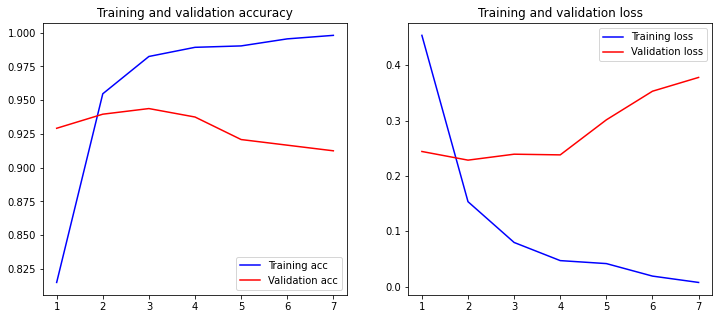

In [10]:
plot_history(history)

In [11]:
model.load_weights(checkpoint_filepath)

In [12]:
results = (model.predict(test_data) > 0.5).astype("int32")

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [14]:
f1 = (f1_score(test_labels_list,results ))*100
f1 = round(f1,2)
print('f1 score is: ',f1)

accuracy = (accuracy_score(test_labels_list,results ))*100
accuracy = round(accuracy,2)
print('accuracy score is: ',accuracy)

precision = (precision_score(test_labels_list,results ))*100
precision = round(precision,2)
print('precision score is: ',precision)

recall = (recall_score(test_labels_list,results ))*100
recall = round(recall,2)
print('recall score is: ',recall)


f1 score is:  94.52
accuracy score is:  94.38
precision score is:  93.95
recall score is:  95.1
